# [Analysing Expected Goals (xG) in Football](#expected-goals)

## [What is xG?](#xg)

Every football match consists of players who attempt to score goals by shooting the ball at the goal. One question that arises in one's mind is, 

> <div class="alert alert-block alert-info">
    <b> What is the probability that the shot will end up in the back of the net?</b> 
</div>

A countless number of factors that include the distance from the goal, if it was shot with a weak foot, the number of players between the player and the goal, the angle of the shot, the build up play to the goal and more can determine this. This probability metric is called Expected Goals metric.

The Expected Goals metric plays a crucial role in player profiling, transfer market trends and team strategies. 
 

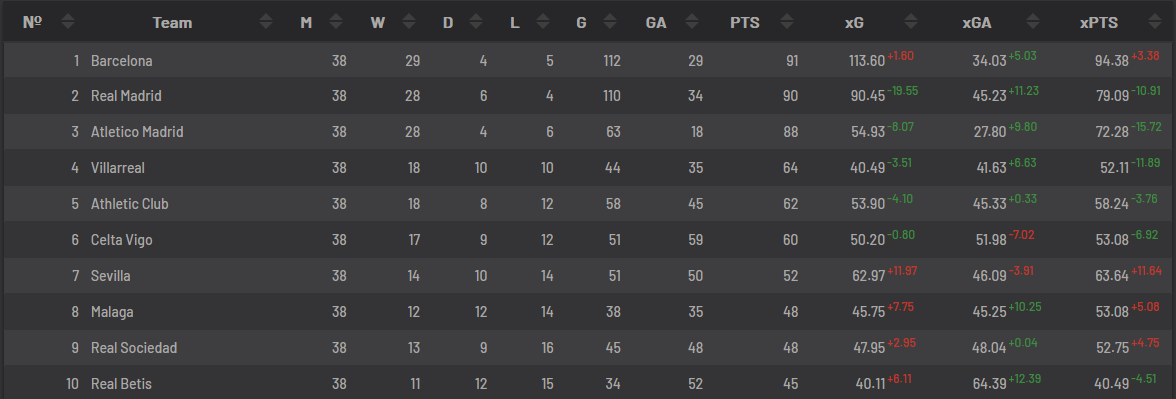

## [Aims and Objectives](#aims-and-objectives)

The aim of this notebook, is to explore the open data provided by __[Statsbomb](http://statsbomb.com)__ to create a model based on Machine Learning to calculate and predict the Expected Goals in football matches. The data that will be used is based on the Barclays FA Women's Super League which is the highest level of football competition for women in England, 2018 Fifa Women's World Cup and the National Women's Soccer League, which is the highest level of football competition for women in the United States and La Liga Men's which is the highest level of football competition in Spain.

<img src="Thesis Notebook.gif" width="750" align="center">
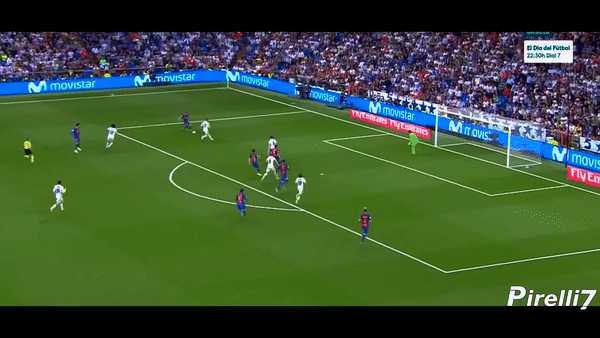

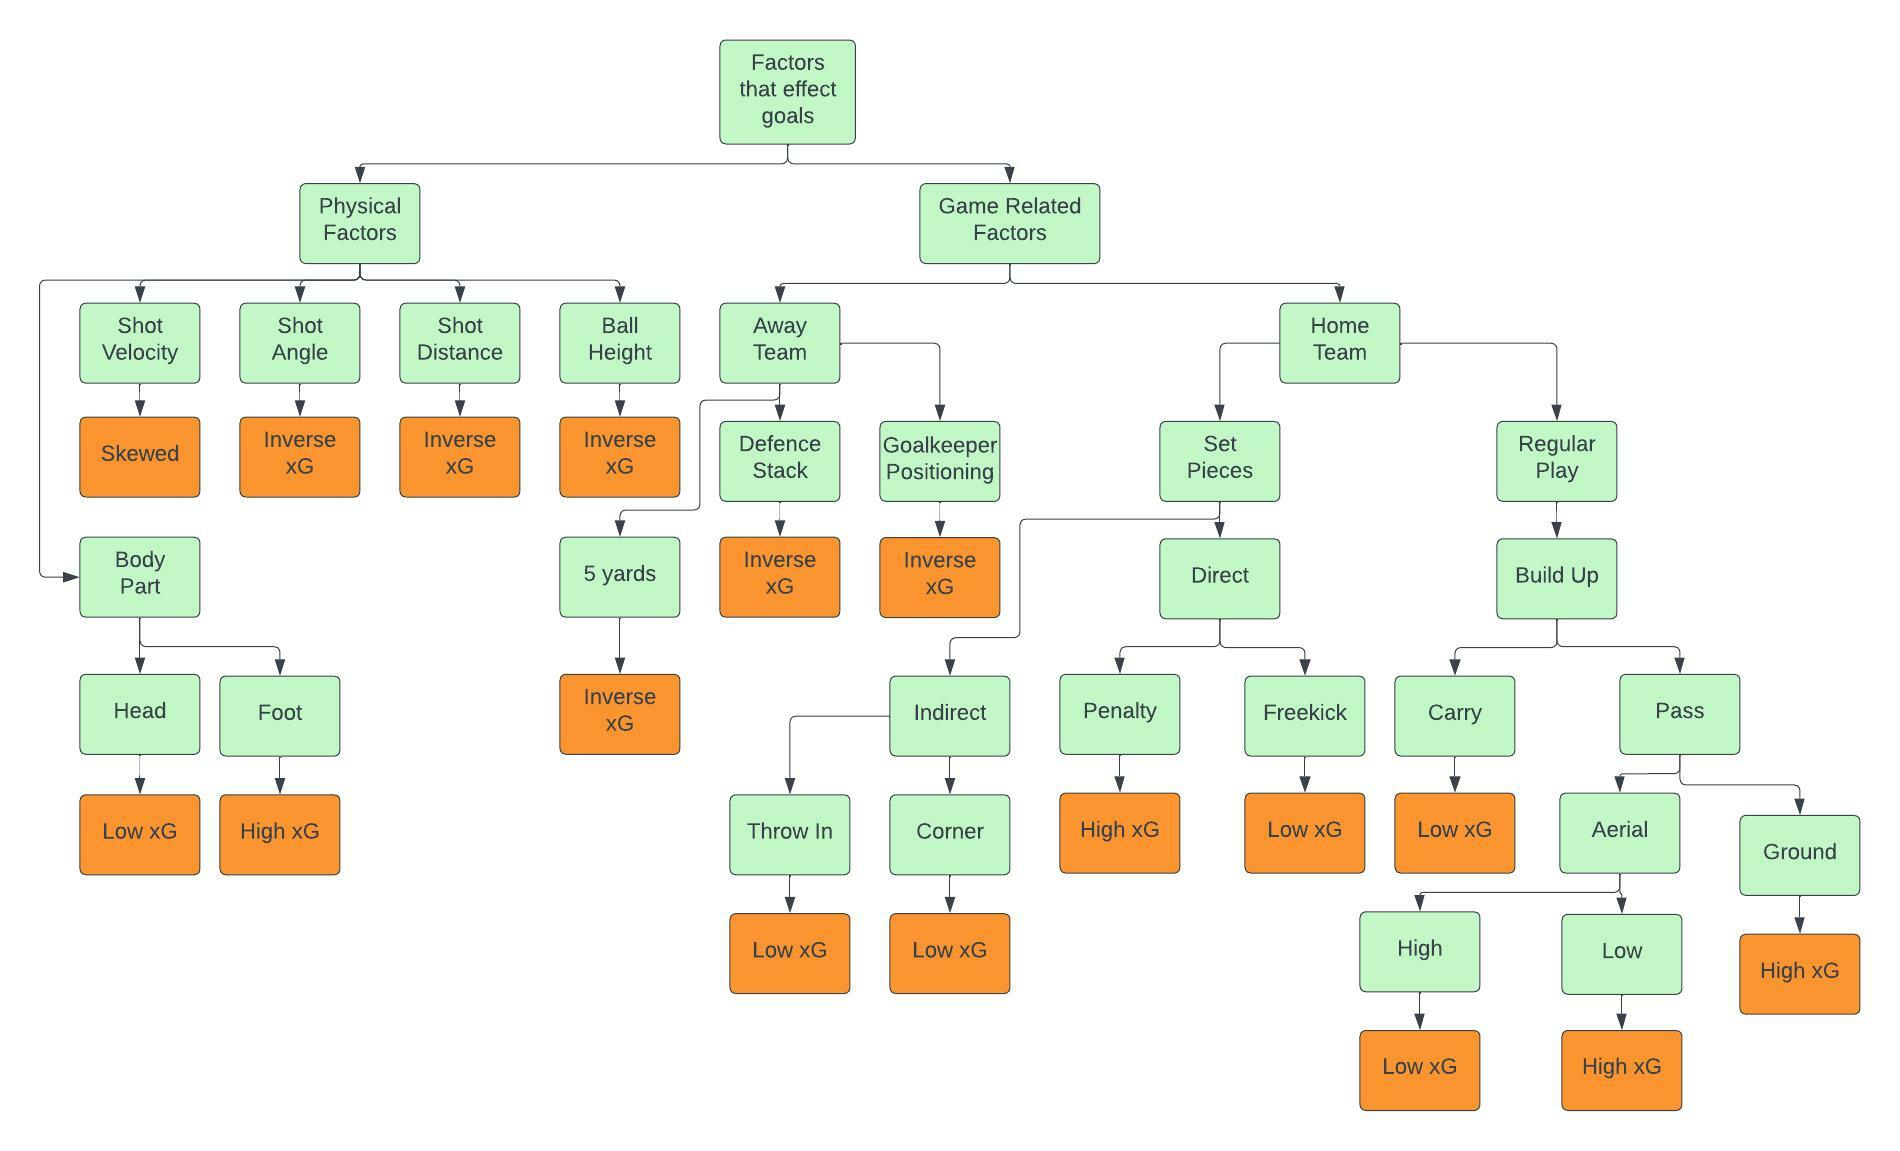

In [2]:
!pip install import-ipynb
!pip install eli5
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 5.1 MB/s 
     |████████████████████████████████| 133 kB 51.6 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=43626b4b4992a062fe97d1aad5feb2716b2f9f82cbab5833b756403eb417284c
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which 

In [3]:
# importing the tools to call google drive
from google.colab import drive


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import uniform

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures,OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

import eli5
import shap
import import_ipynb

In [4]:
# mount our directory
mount='/content/gdrive'
drive.mount(mount, force_remount=True)

Mounted at /content/gdrive


In [5]:
# Switch to the directory on the VM for our purposes
drive_root=mount + '/My Drive/Colab Notebooks/Thesis'
%cd $drive_root
%pwd

/content/gdrive/My Drive/Colab Notebooks/Thesis


'/content/gdrive/My Drive/Colab Notebooks/Thesis'

In [6]:
import Pitch_Plot
import data
from data import obtain_seasons,fetch_url,Game
from Pitch_Plot import pitchplot

importing Jupyter notebook from Pitch_Plot.ipynb
importing Jupyter notebook from data.ipynb


In [7]:
df = pd.read_pickle('./final_data.pkl')

In [8]:
df.columns

Index(['shot id', 'play pattern', 'x location shot', 'y location shot',
       'duration', 'outcome', 'technique used', 'first time', 'x gk location',
       'y gk location', 'body part', 'type of shot',
       'Number of opponents in 5 yards', 'Players between goal', 'player name',
       'Team Name', 'official xg', 'Pass id', 'Pass Type', 'game_id',
       'season_id', 'distance_from_goalpost_a', 'distance_from_goalpost_b',
       'shot_angle'],
      dtype='object')

In [9]:
df['shot distance'] = round(np.sqrt((df['x location shot']-120)**2+(df['y location shot']-40)**2),1)

In [10]:
df['gk distance'] = round(np.sqrt((df['x gk location']-120)**2+(df['y gk location']-40)**2),1)
df

shot id    play pattern  x location shot  \
0      56deeffa-ff55-429e-91df-41f237a3ebac    Regular Play            103.7   
1      00d9c066-1078-4e1c-8c7f-2ca299e3a5f0  From Free Kick            107.4   
2      48706448-928f-4721-96ec-2b813f448937    Regular Play            108.5   
3      718f8a06-078c-489e-9423-63d414be5e43   From Throw In            106.0   
4      e1b29724-4861-4d12-9a51-ac6635e97438     From Corner            112.4   
...                                     ...             ...              ...   
23512  4468faac-ae6a-4637-928b-fc7dd448411b  From Free Kick             91.1   
23513  5f613006-c00e-4581-882c-a7a81978ebf0   From Throw In            103.7   
23514  717c9351-6eff-4f71-969a-e25bab5bfcb6   From Throw In            107.9   
23515  0c914938-af14-479e-8043-8e4bfdfd474d   From Throw In            117.8   
23516  d9533117-d840-4973-91cd-9472a76d705e  From Free Kick            108.5   

       y location shot  duration outcome technique used  first time  \
0                 46.3  0.909600   Saved         Normal        True   
1                 37.4  1.033500    Goal         Normal       False   
2                 48.1  1.391602   Off T         Normal       False   
3                 43.7  1.154700   Saved         Normal       False   
4                 42.9  0.907511   Off T         Normal       False   
...                ...       ...     ...            ...         ...   
23512             47.1  1.622413    Post         Normal       False   
23513             33.6  1.070861   Off T    Half Volley       False   
23514             37.0  0.701300   Saved         Volley        True   
23515             43.9  1.256200    Post         Normal       False   
23516             45.6  1.316500   Off T         Normal       False   

       x gk location  y gk location  ... official xg  \
0              116.0           43.0  ...    0.174474   
1              118.3           39.9  ...    0.028797   
2              118.9           42.8  ...    0.027564   
3              118.9           42.1  ...    0.025206   
4              119.3           40.7  ...    0.065884   
...              ...            ...  ...         ...   
23512          118.4           40.8  ...    0.049559   
23513          119.5           39.8  ...    0.057103   
23514          119.2           39.6  ...    0.113389   
23515          118.9           43.3  ...    0.415576   
23516          119.6           41.4  ...    0.051609   

                                    Pass id    Pass Type  game_id  season_id  \
0      448cb3aa-ee0b-4829-a7d4-bdef6dfda5bd  Ground Pass    68311       2019   
1      f5d55ee4-2db3-4604-b9fa-8bd0645fdc4b    High Pass    68311       2019   
2      13eaef4e-1393-4b99-b94d-d60c35070713    High Pass    68311       2019   
3      be417f5e-798b-4dd0-a651-4b7a9d2e3564    High Pass    68311       2019   
4      ef4852cb-22f5-4afe-8355-5ec0752f9adb    High Pass    68311       2019   
...                                     ...          ...      ...        ...   
23512                               No Pass         None    68353  2004/2005   
23513                               No Pass         None    68353  2004/2005   
23514  dbaca88f-32d3-4abe-a37d-4fceb67a4302     Low Pass    68353  2004/2005   
23515                               No Pass         None    68353  2004/2005   
23516  f2137b0f-01b5-4311-8eea-955918e63892    High Pass    68353  2004/2005   

      distance_from_goalpost_a  distance_from_goalpost_b shot_angle  \
0                    19.281597                 16.461470       24.3   
1                    12.677539                 14.223924       34.0   
2                    16.693112                 12.209013       26.8   
3                    15.977797                 14.003214       30.0   
4                    10.264989                  7.679193       50.5   
...                        ...                       ...        ...   
23512                30.958359                 29.065787       14.9   
23513               

In [11]:
df.set_index("shot id")

play pattern  x location shot  \
shot id                                                                 
56deeffa-ff55-429e-91df-41f237a3ebac    Regular Play            103.7   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0  From Free Kick            107.4   
48706448-928f-4721-96ec-2b813f448937    Regular Play            108.5   
718f8a06-078c-489e-9423-63d414be5e43   From Throw In            106.0   
e1b29724-4861-4d12-9a51-ac6635e97438     From Corner            112.4   
...                                              ...              ...   
4468faac-ae6a-4637-928b-fc7dd448411b  From Free Kick             91.1   
5f613006-c00e-4581-882c-a7a81978ebf0   From Throw In            103.7   
717c9351-6eff-4f71-969a-e25bab5bfcb6   From Throw In            107.9   
0c914938-af14-479e-8043-8e4bfdfd474d   From Throw In            117.8   
d9533117-d840-4973-91cd-9472a76d705e  From Free Kick            108.5   

                                      y location shot  duration outcome  \
shot id                                                                   
56deeffa-ff55-429e-91df-41f237a3ebac             46.3  0.909600   Saved   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0             37.4  1.033500    Goal   
48706448-928f-4721-96ec-2b813f448937             48.1  1.391602   Off T   
718f8a06-078c-489e-9423-63d414be5e43             43.7  1.154700   Saved   
e1b29724-4861-4d12-9a51-ac6635e97438             42.9  0.907511   Off T   
...                                               ...       ...     ...   
4468faac-ae6a-4637-928b-fc7dd448411b             47.1  1.622413    Post   
5f613006-c00e-4581-882c-a7a81978ebf0             33.6  1.070861   Off T   
717c9351-6eff-4f71-969a-e25bab5bfcb6             37.0  0.701300   Saved   
0c914938-af14-479e-8043-8e4bfdfd474d             43.9  1.256200    Post   
d9533117-d840-4973-91cd-9472a76d705e             45.6  1.316500   Off T   

                                     technique used  first time  \
shot id                                                           
56deeffa-ff55-429e-91df-41f237a3ebac         Normal        True   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0         Normal       False   
48706448-928f-4721-96ec-2b813f448937         Normal       False   
718f8a06-078c-489e-9423-63d414be5e43         Normal       False   
e1b29724-4861-4d12-9a51-ac6635e97438         Normal       False   
...                                             ...         ...   
4468faac-ae6a-4637-928b-fc7dd448411b         Normal       False   
5f613006-c00e-4581-882c-a7a81978ebf0    Half Volley       False   
717c9351-6eff-4f71-969a-e25bab5bfcb6         Volley        True   
0c914938-af14-479e-8043-8e4bfdfd474d         Normal       False   
d9533117-d840-4973-91cd-9472a76d705e         Normal       False   

                                      x gk location  y gk location  \
shot id                                                              
56deeffa-ff55-429e-91df-41f237a3ebac          116.0           43.0   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0          118.3           39.9   
48706448-928f-4721-96ec-2b813f448937          118.9           42.8   
718f8a06-078c-489e-9423-63d414be5e43          118.9           42.1   
e1b29724-4861-4d12-9a51-ac6635e97438          119.3           40.7   
...                                             ...            ...   
4468faac-ae6a-4637-928b-fc7dd448411b          118.4           40.8   
5f613006-c00e-4581-882c-a7a81978ebf0          119.5           39.8   
717c9351-6eff-4f71-969a-e25bab5bfcb6          119.2           39.6   
0c914938-af14-479e-8043-8e4bfdfd474d          118.9           43.3   
d9533117-d840-4973-91cd-9472a76d705e          119.6           41.4   

                                       body part  ... official xg  \
shot id                                           ...               
56deeffa-ff55-429e-91df-41f237a3ebac  Right Foot  ...    0.174474   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0        Head  ...    0.028797   
48706448-928f-4721-96ec-2b813f448937        Head  ...  

In [12]:
Goal_label = []
binary_outcome = []
for outcome in df['outcome'].values:
    if outcome == 'Goal':
        Goal_label.append('Goal')
        binary_outcome.append(1)
    else:
        Goal_label.append('Not Goal')
        binary_outcome.append(0)
df['Goal_label'] = Goal_label
df['binary_outcome'] = binary_outcome

In [13]:
df = df.set_index("shot id")
df

play pattern  x location shot  \
shot id                                                                 
56deeffa-ff55-429e-91df-41f237a3ebac    Regular Play            103.7   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0  From Free Kick            107.4   
48706448-928f-4721-96ec-2b813f448937    Regular Play            108.5   
718f8a06-078c-489e-9423-63d414be5e43   From Throw In            106.0   
e1b29724-4861-4d12-9a51-ac6635e97438     From Corner            112.4   
...                                              ...              ...   
4468faac-ae6a-4637-928b-fc7dd448411b  From Free Kick             91.1   
5f613006-c00e-4581-882c-a7a81978ebf0   From Throw In            103.7   
717c9351-6eff-4f71-969a-e25bab5bfcb6   From Throw In            107.9   
0c914938-af14-479e-8043-8e4bfdfd474d   From Throw In            117.8   
d9533117-d840-4973-91cd-9472a76d705e  From Free Kick            108.5   

                                      y location shot  duration outcome  \
shot id                                                                   
56deeffa-ff55-429e-91df-41f237a3ebac             46.3  0.909600   Saved   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0             37.4  1.033500    Goal   
48706448-928f-4721-96ec-2b813f448937             48.1  1.391602   Off T   
718f8a06-078c-489e-9423-63d414be5e43             43.7  1.154700   Saved   
e1b29724-4861-4d12-9a51-ac6635e97438             42.9  0.907511   Off T   
...                                               ...       ...     ...   
4468faac-ae6a-4637-928b-fc7dd448411b             47.1  1.622413    Post   
5f613006-c00e-4581-882c-a7a81978ebf0             33.6  1.070861   Off T   
717c9351-6eff-4f71-969a-e25bab5bfcb6             37.0  0.701300   Saved   
0c914938-af14-479e-8043-8e4bfdfd474d             43.9  1.256200    Post   
d9533117-d840-4973-91cd-9472a76d705e             45.6  1.316500   Off T   

                                     technique used  first time  \
shot id                                                           
56deeffa-ff55-429e-91df-41f237a3ebac         Normal        True   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0         Normal       False   
48706448-928f-4721-96ec-2b813f448937         Normal       False   
718f8a06-078c-489e-9423-63d414be5e43         Normal       False   
e1b29724-4861-4d12-9a51-ac6635e97438         Normal       False   
...                                             ...         ...   
4468faac-ae6a-4637-928b-fc7dd448411b         Normal       False   
5f613006-c00e-4581-882c-a7a81978ebf0    Half Volley       False   
717c9351-6eff-4f71-969a-e25bab5bfcb6         Volley        True   
0c914938-af14-479e-8043-8e4bfdfd474d         Normal       False   
d9533117-d840-4973-91cd-9472a76d705e         Normal       False   

                                      x gk location  y gk location  \
shot id                                                              
56deeffa-ff55-429e-91df-41f237a3ebac          116.0           43.0   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0          118.3           39.9   
48706448-928f-4721-96ec-2b813f448937          118.9           42.8   
718f8a06-078c-489e-9423-63d414be5e43          118.9           42.1   
e1b29724-4861-4d12-9a51-ac6635e97438          119.3           40.7   
...                                             ...            ...   
4468faac-ae6a-4637-928b-fc7dd448411b          118.4           40.8   
5f613006-c00e-4581-882c-a7a81978ebf0          119.5           39.8   
717c9351-6eff-4f71-969a-e25bab5bfcb6          119.2           39.6   
0c914938-af14-479e-8043-8e4bfdfd474d          118.9           43.3   
d9533117-d840-4973-91cd-9472a76d705e          119.6           41.4   

                                       body part  ...    Pass Type  game_id  \
shot id                                           ...                         
56deeffa-ff55-429e-91df-41f237a3ebac  Right Foot  ...  Ground Pass    68311   
00d9c066-1078-4e1c-8c7f-2ca299e3a5f0        Head  ...    High Pass    68311   
48706448-928f-4

# Creating training, testing and validation data


In [14]:
features = df.drop(["outcome"], axis=1)
targets = df["outcome"]

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(features.loc[X_train.index], targets[X_train.index], test_size=0.2)

train = pd.merge(X_train, y_train, left_index=True, right_index=True)
validate = pd.merge(X_valid, y_valid, left_index=True, right_index=True)
test = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [15]:
train.columns

Index(['play pattern', 'x location shot', 'y location shot', 'duration',
       'technique used', 'first time', 'x gk location', 'y gk location',
       'body part', 'type of shot', 'Number of opponents in 5 yards',
       'Players between goal', 'player name', 'Team Name', 'official xg',
       'Pass id', 'Pass Type', 'game_id', 'season_id',
       'distance_from_goalpost_a', 'distance_from_goalpost_b', 'shot_angle',
       'shot distance', 'gk distance', 'Goal_label', 'binary_outcome',
       'outcome'],
      dtype='object')

In [16]:
train

play pattern  x location shot  \
shot id                                                                 
57a31341-b318-4055-8563-53e9eeba4b04  From Free Kick            103.3   
106da9df-800f-4cd0-95a0-63237602351c  From Free Kick             99.2   
32d14f10-5858-4aca-b293-b22425e230c1    Regular Play            114.0   
8a21d58a-449c-4fb1-8855-47020bd8f143    From Counter            102.5   
d92e5844-0a73-4ec4-adc5-9db85c2fae3c  From Free Kick            107.2   
...                                              ...              ...   
ef90f815-f71c-4731-add0-7bd52c276616     From Corner            108.8   
5873249f-901e-4e45-9126-b36e5a5f84bd    Regular Play             96.4   
3e5a13cc-f98a-431d-99a1-398205cf519e  From Goal Kick            100.1   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0    Regular Play            100.0   
d6c171af-f75b-4e6f-91ef-4f470b582d35     From Corner            118.8   

                                      y location shot  duration  \
shot id                                                           
57a31341-b318-4055-8563-53e9eeba4b04             52.3  1.324041   
106da9df-800f-4cd0-95a0-63237602351c             22.9  1.746710   
32d14f10-5858-4aca-b293-b22425e230c1             42.0  0.551904   
8a21d58a-449c-4fb1-8855-47020bd8f143             48.0  0.492520   
d92e5844-0a73-4ec4-adc5-9db85c2fae3c             41.1  0.405000   
...                                               ...       ...   
ef90f815-f71c-4731-add0-7bd52c276616             39.0  1.634946   
5873249f-901e-4e45-9126-b36e5a5f84bd             21.6  1.537515   
3e5a13cc-f98a-431d-99a1-398205cf519e             53.6  0.741960   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0             19.0  0.760000   
d6c171af-f75b-4e6f-91ef-4f470b582d35             39.0  0.299417   

                                     technique used  first time  \
shot id                                                           
57a31341-b318-4055-8563-53e9eeba4b04         Normal       False   
106da9df-800f-4cd0-95a0-63237602351c         Normal       False   
32d14f10-5858-4aca-b293-b22425e230c1         Volley        True   
8a21d58a-449c-4fb1-8855-47020bd8f143         Normal       False   
d92e5844-0a73-4ec4-adc5-9db85c2fae3c         Normal       False   
...                                             ...         ...   
ef90f815-f71c-4731-add0-7bd52c276616         Normal       False   
5873249f-901e-4e45-9126-b36e5a5f84bd         Normal       False   
3e5a13cc-f98a-431d-99a1-398205cf519e         Normal       False   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0         Normal        True   
d6c171af-f75b-4e6f-91ef-4f470b582d35         Normal       False   

                                      x gk location  y gk location  \
shot id                                                              
57a31341-b318-4055-8563-53e9eeba4b04          119.1           40.6   
106da9df-800f-4cd0-95a0-63237602351c          119.6           36.6   
32d14f10-5858-4aca-b293-b22425e230c1          119.0           39.0   
8a21d58a-449c-4fb1-8855-47020bd8f143          112.1           42.8   
d92e5844-0a73-4ec4-adc5-9db85c2fae3c          119.3           40.4   
...                                             ...            ...   
ef90f815-f71c-4731-add0-7bd52c276616          119.2           40.0   
5873249f-901e-4e45-9126-b36e5a5f84bd          119.0           41.1   
3e5a13cc-f98a-431d-99a1-398205cf519e          119.0           43.2   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0          119.0           37.0   
d6c171af-f75b-4e6f-91ef-4f470b582d35          120.0           39.3   

                                       body part type of shot  ...  game_id  \
shot id                                                        ...            
57a31341-b318-4055-8563-53e9eeba4b04   Left Foot    Open Play  ...  3775542   
106da9df-800f-4cd0-95a0-63237602351c  Right Foot    Open Play  ...    19756   
32d14f10-5858-4aca-b293-b22425e230c1   Left Foot    Open Play  ...    19754   
8a21d58a-449c-4fb1-8855-47020bd8f143  Ri

In [17]:
df_regular_play = train[train['play pattern']=='Regular Play']
df_regular_play

play pattern  x location shot  \
shot id                                                               
32d14f10-5858-4aca-b293-b22425e230c1  Regular Play            114.0   
fc23ff68-4186-4e45-af1e-2b836760f9ca  Regular Play            106.0   
c978873c-d0a1-4872-a6b3-7211eda12356  Regular Play            100.7   
9f50ac74-d4bd-4d45-ac4a-3c1937e2120e  Regular Play             83.7   
7d4dff8d-dd8f-4e4b-9f69-fb2a5273c2ab  Regular Play            108.0   
...                                            ...              ...   
3e7681b6-08ed-46fa-8d56-75d08e74c641  Regular Play             86.0   
5cdc0dad-f528-4ca6-8bf5-43b55af9a2e1  Regular Play            106.8   
2297634e-0a4a-4442-a94f-2a6bd4413b9f  Regular Play            112.0   
5873249f-901e-4e45-9126-b36e5a5f84bd  Regular Play             96.4   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0  Regular Play            100.0   

                                      y location shot  duration  \
shot id                                                           
32d14f10-5858-4aca-b293-b22425e230c1             42.0  0.551904   
fc23ff68-4186-4e45-af1e-2b836760f9ca             55.0  1.443729   
c978873c-d0a1-4872-a6b3-7211eda12356             33.5  0.863376   
9f50ac74-d4bd-4d45-ac4a-3c1937e2120e             28.7  1.204469   
7d4dff8d-dd8f-4e4b-9f69-fb2a5273c2ab             49.0  0.359735   
...                                               ...       ...   
3e7681b6-08ed-46fa-8d56-75d08e74c641             45.0  0.392533   
5cdc0dad-f528-4ca6-8bf5-43b55af9a2e1             34.0  0.254800   
2297634e-0a4a-4442-a94f-2a6bd4413b9f             57.0  1.047924   
5873249f-901e-4e45-9126-b36e5a5f84bd             21.6  1.537515   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0             19.0  0.760000   

                                     technique used  first time  \
shot id                                                           
32d14f10-5858-4aca-b293-b22425e230c1         Volley        True   
fc23ff68-4186-4e45-af1e-2b836760f9ca         Normal       False   
c978873c-d0a1-4872-a6b3-7211eda12356         Normal        True   
9f50ac74-d4bd-4d45-ac4a-3c1937e2120e         Normal       False   
7d4dff8d-dd8f-4e4b-9f69-fb2a5273c2ab         Normal       False   
...                                             ...         ...   
3e7681b6-08ed-46fa-8d56-75d08e74c641         Normal       False   
5cdc0dad-f528-4ca6-8bf5-43b55af9a2e1         Normal       False   
2297634e-0a4a-4442-a94f-2a6bd4413b9f         Normal       False   
5873249f-901e-4e45-9126-b36e5a5f84bd         Normal       False   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0         Normal        True   

                                      x gk location  y gk location  \
shot id                                                              
32d14f10-5858-4aca-b293-b22425e230c1          119.0           39.0   
fc23ff68-4186-4e45-af1e-2b836760f9ca          120.0           41.0   
c978873c-d0a1-4872-a6b3-7211eda12356          118.6           37.7   
9f50ac74-d4bd-4d45-ac4a-3c1937e2120e          116.2           38.0   
7d4dff8d-dd8f-4e4b-9f69-fb2a5273c2ab          116.0           42.0   
...                                             ...            ...   
3e7681b6-08ed-46fa-8d56-75d08e74c641          119.0           41.0   
5cdc0dad-f528-4ca6-8bf5-43b55af9a2e1          118.7           39.4   
2297634e-0a4a-4442-a94f-2a6bd4413b9f          118.0           43.0   
5873249f-901e-4e45-9126-b36e5a5f84bd          119.0           41.1   
4fe2dc03-dabc-4b78-8863-7a4df869a7f0          119.0           37.0   

                                       body part type of shot  ...  game_id  \
shot id                                                        ...            
32d14f10-5858-4aca-b293-b22425e230c1   Left Foot    Open Play  ...    19754   
fc23ff68-4186-4e45-af1e-2b836760f9ca  Right Foot    Open Play  ...    19718   
c978873c-d0a1-4872-a6b3-7211eda12356   Left Foot    Open Play  ...     9855   
9f50ac74-d4bd-4d45-ac4a-3c1937e2120e   Left Foot    Open Play  .

Let's check how distance has an affect on expected goals followed by angle.

In [18]:
def goals(fig,locations,color,label):
    loc_x=[]
    loc_y=[]
    for loc in locations:
        loc_x.append(loc[0])
        loc_y.append(loc[1])        
    plt.scatter(loc_x,loc_y,c=color,alpha=0.6,label=label,edgecolor='black',linewidth=0.5)
    plt.axis('off')
    return fig

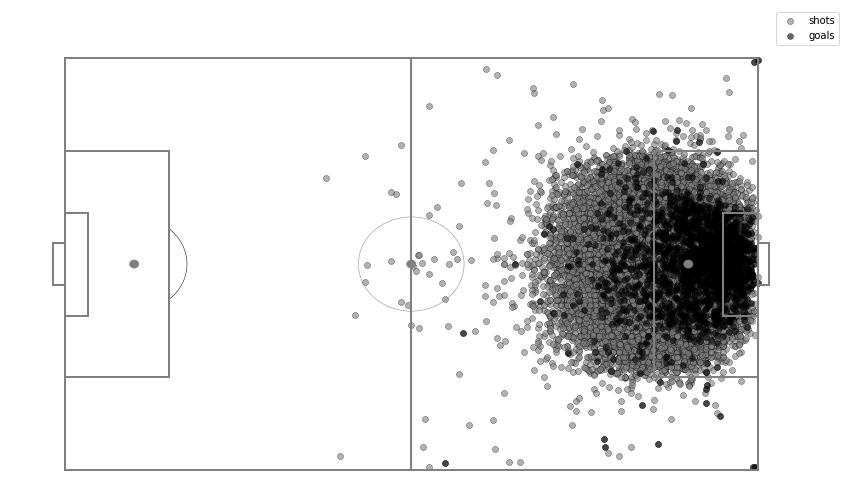

In [19]:
pitch = pitchplot()
pitch = goals(plt,train[['x location shot','y location shot']].values,'grey','shots')
pitch = goals(plt,train[train['Goal_label']=='Goal'][['x location shot','y location shot']].values,'black','goals')
plt.legend(loc='upper right')
plt.show()

In [20]:
def allgoals(fig,df):    
    sns.histplot(data=df_regular_play, x="x location shot", y="y location shot",cbar=True,cbar_kws=dict(shrink=.25), pmax=0.85, palette='Reds')
    #px.density_heatmap(df_regular_play, x="x location shot",y ="y location shot")
    plt.axis('off')
    return plt

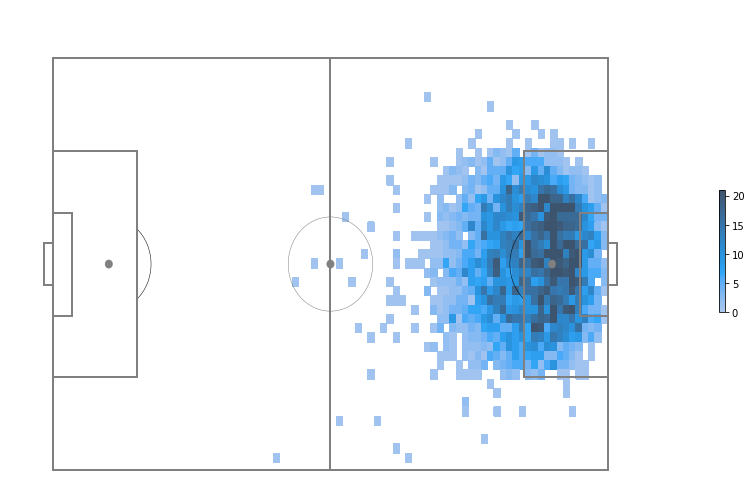

In [21]:
df_goals = df_regular_play[df_regular_play['Goal_label']=='Goal']
pitch = pitchplot()
pitch = allgoals(pitch,df_goals)
plt.show()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


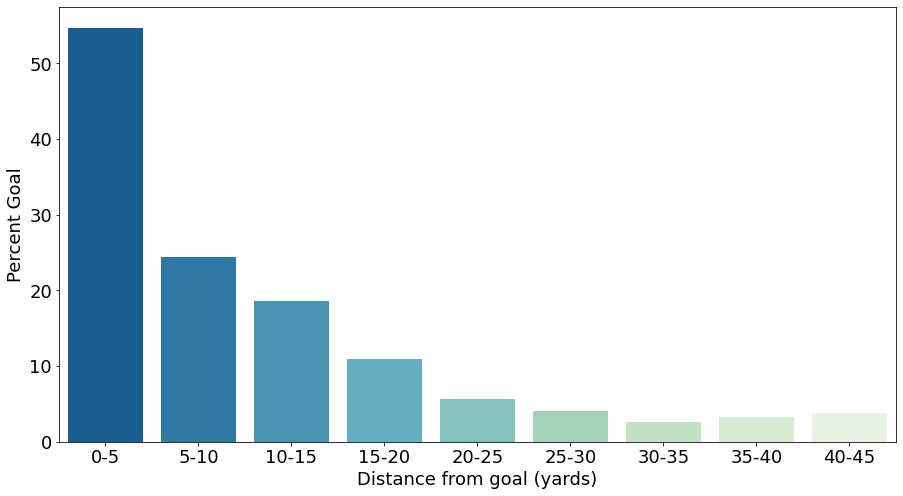

In [22]:
distance = train[["shot distance", "binary_outcome"]]
distance["shot distance"] = distance["shot distance"].floordiv(5)
distance["binary_outcome"] = pd.to_numeric(distance["binary_outcome"]) * 100
outcome = distance.groupby("shot distance").mean().reset_index().iloc[0:9]

fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.barplot(data=outcome,x="shot distance", y="binary_outcome", ax=ax, palette='GnBu_r')
plt.xticks(np.arange(9), ("0-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-35", "35-40", "40-45"))
plt.xlabel("Distance from goal (yards)", size=18)
plt.ylabel("Percent Goal", size=18)
plt.tick_params(labelsize=18)

Clearly the number of goals are reducing as the distance is increasing. Most of the goals are scored from within the box.

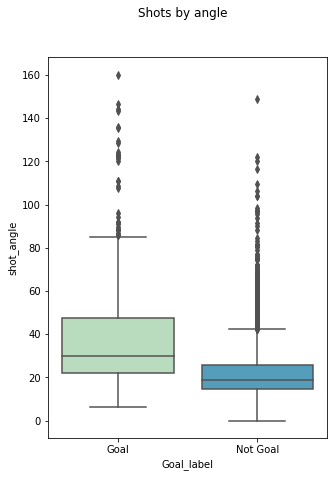

In [23]:
fig,ax=plt.subplots(1,1,figsize=(5,7))
fig.suptitle('Shots by angle')
sns.boxplot(x='Goal_label',y='shot_angle',data=df_regular_play, palette = 'GnBu')

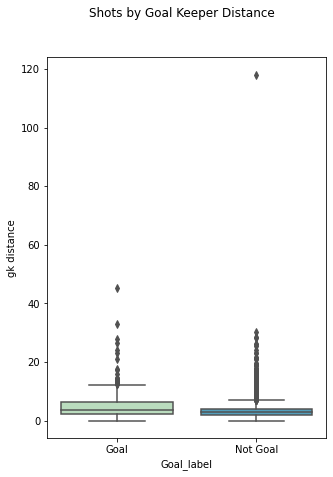

In [24]:
fig,ax=plt.subplots(1,1,figsize=(5,7))
fig.suptitle('Shots by Goal Keeper Distance')
sns.boxplot(x='Goal_label',y='gk distance',data=df_regular_play, palette = 'GnBu')

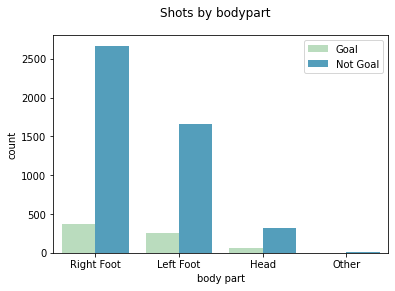

In [25]:
fig,ax=plt.subplots(1,1)
fig.suptitle('Shots by bodypart')
sns.countplot(x='body part',order=['Right Foot','Left Foot','Head','Other'],hue='Goal_label',data=df_regular_play, palette = 'GnBu')
plt.legend(loc='upper right')

In [26]:
footed_shots = (df_regular_play['body part']=='Right Foot') | (df_regular_play['body part']=='Left Foot')
shots_from_foot = df_regular_play[footed_shots].shape[0]
goals_from_foot = sum(df_regular_play[footed_shots]['binary_outcome'])

headed_shots = (df_regular_play['body part']=='Head')
shots_from_head = df_regular_play[headed_shots].shape[0]
goals_from_head = sum(df_regular_play[headed_shots]['binary_outcome'])

feetperc = goals_from_foot/shots_from_foot
headperc = goals_from_head/shots_from_head

print(feetperc*100,'%')
print(headperc*100,'%')

12.653884964682138 %
15.733333333333333 %


This shows that headed goals are more effective than footed goals. There is a skewness of that we need to consider first.

Text(0.5, 1.0, 'Headed Shots')

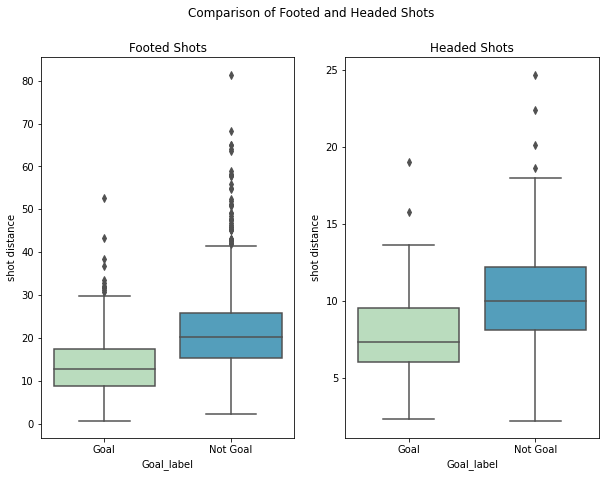

In [27]:
fig,axis = plt.subplots(1,2, figsize=(10,7))
fig.suptitle('Comparison of Footed and Headed Shots')
sns.boxplot(x='Goal_label',y='shot distance',data=df_regular_play[footed_shots],ax=axis[0],palette='GnBu')
sns.boxplot(x='Goal_label',y='shot distance',data=df_regular_play[headed_shots],ax=axis[1],palette='GnBu')
axis[0].set_title('Footed Shots')
axis[1].set_title('Headed Shots')

This figure shows that almost all headed shots are taken from a distance of 18 yards.

In [28]:
eighteen_yardf = df_regular_play[footed_shots]['shot distance']<18
footed18_shots = df_regular_play[footed_shots][eighteen_yardf].shape[0]
footed18_goals = sum(df_regular_play[footed_shots][eighteen_yardf]['binary_outcome'])

eighteen_yardh = df_regular_play[headed_shots]['shot distance']<18
headed18_shots = df_regular_play[headed_shots][eighteen_yardh].shape[0]
headed18_goals = sum(df_regular_play[headed_shots][eighteen_yardh]['binary_outcome'])

feetperc18 = footed18_goals/footed18_shots
headperc18 = headed18_goals/headed18_shots

print(feetperc18*100,'%')
print(headperc18*100,'%')

22.56267409470752 %
15.718157181571815 %


After checking the goals from the 18 yard distance, it is clear that the footed goals are more effective. 

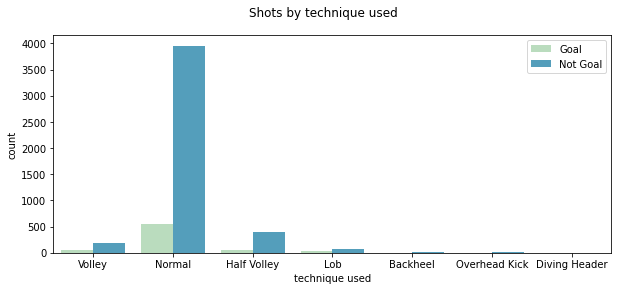

In [29]:
fig,ax=plt.subplots(1,1, figsize=(10,4))
fig.suptitle('Shots by technique used')
sns.countplot(x='technique used',hue='Goal_label',data=df_regular_play, palette = 'GnBu')
plt.legend(loc='upper right')

In [30]:
normal_shots = (df_regular_play['technique used']=='Normal') 
volley_shots = (df_regular_play['technique used']=='Volley')
halfvolley_shots = (df_regular_play['technique used']=='Half Volley')
other_shots = (df_regular_play['technique used']=='Lob technique used') | (df_regular_play['technique used']!='Backheel') | (df_regular_play['technique used']!='Diving Header') | (df_regular_play['technique used']!='Overhead Kick')

In [31]:
shots_normal = df_regular_play[normal_shots].shape[0]
goals_normal = sum(df_regular_play[normal_shots]['binary_outcome'])
perc_normal = goals_normal/shots_normal*100

shots_volley = df_regular_play[volley_shots].shape[0]
goals_volley = sum(df_regular_play[volley_shots]['binary_outcome'])
perc_volley = goals_volley/shots_volley*100

shots_halfvolley = df_regular_play[halfvolley_shots].shape[0]
goals_halfvolley = sum(df_regular_play[halfvolley_shots]['binary_outcome'])
perc_halfvolley = goals_halfvolley/shots_halfvolley*100

shots_other = df_regular_play[other_shots].shape[0]
goals_other = sum(df_regular_play[other_shots]['binary_outcome'])
perc_other = goals_other/shots_other*100

print(perc_normal)
print(perc_volley)
print(perc_halfvolley)
print(perc_other)

12.047121582573904
20.0
12.391304347826088
12.869988759835143


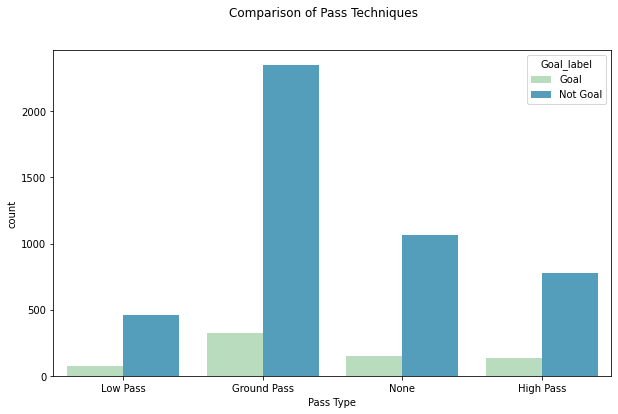

In [32]:
fig,axis = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Comparison of Pass Techniques')
sns.countplot(x='Pass Type',data=df_regular_play,hue ='Goal_label',ax=axis,palette='GnBu')

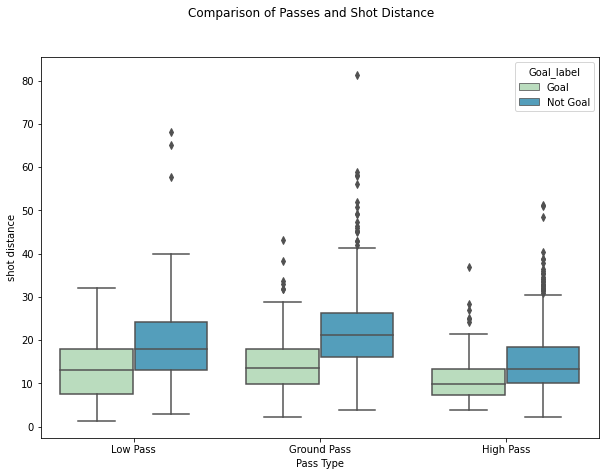

In [33]:
fig,axis = plt.subplots(1,1, figsize=(10,7))
fig.suptitle('Comparison of Passes and Shot Distance')
df_none = df_regular_play[df_regular_play['Pass Type']!='None']
sns.boxplot(x='Pass Type',y='shot distance',data=df_none,hue='Goal_label',ax=axis,palette='GnBu')

Text(0, 0.5, 'Proportion of Goals from Resulting Shots')

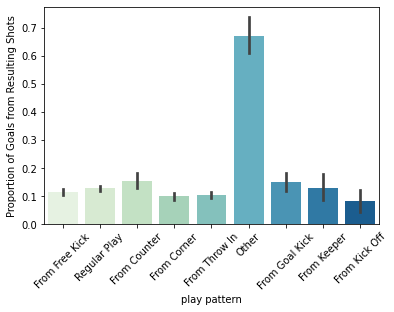

In [34]:
sns.barplot(y='binary_outcome',x='play pattern',data=train,palette='GnBu')
plt.xticks(rotation=45)
plt.ylabel('Proportion of Goals from Resulting Shots')

In [35]:
train['play pattern'].value_counts()

Regular Play      5338
From Free Kick    3006
From Throw In     2618
From Corner       2268
From Counter       723
From Goal Kick     518
Other              214
From Keeper        185
From Kick Off      179
Name: play pattern, dtype: int64

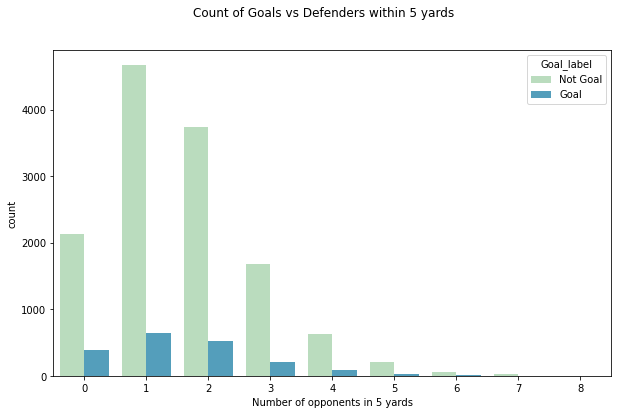

In [36]:
fig,axis = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Count of Goals vs Defenders within 5 yards')
sns.countplot(x='Number of opponents in 5 yards',data=train,hue ='Goal_label',ax=axis, palette='GnBu')

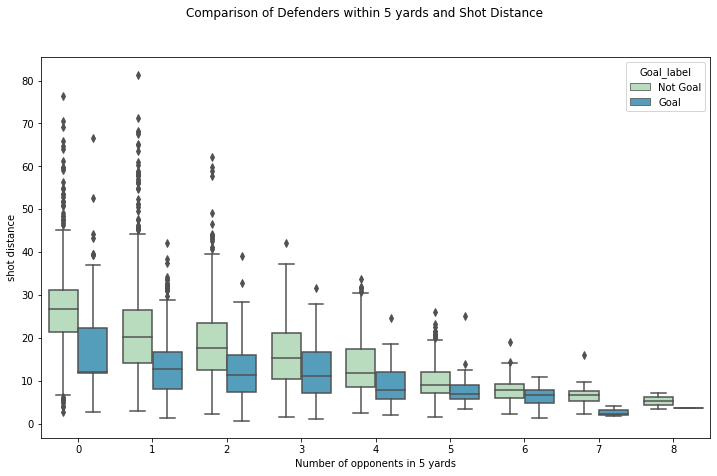

In [37]:
fig,axis = plt.subplots(1,1, figsize=(12,7))
fig.suptitle('Comparison of Defenders within 5 yards and Shot Distance')
df_none = df_regular_play[df_regular_play['Pass Type']!='None']
sns.boxplot(x='Number of opponents in 5 yards',y='shot distance',data=train,hue='Goal_label',ax=axis, palette='GnBu')

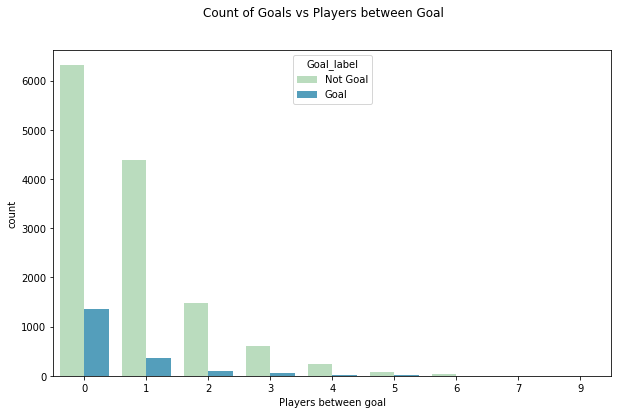

In [38]:
fig,axis = plt.subplots(1,1, figsize=(10,6))
fig.suptitle('Count of Goals vs Players between Goal')
sns.countplot(x='Players between goal',data=train,hue ='Goal_label',ax=axis,palette='GnBu')

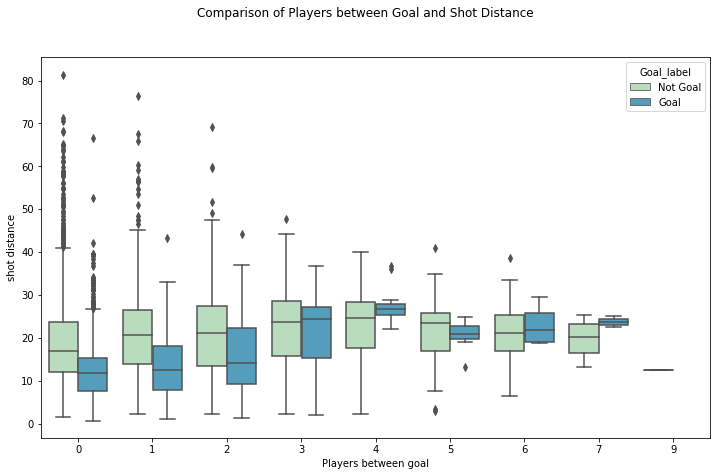

In [39]:
fig,axis = plt.subplots(1,1, figsize=(12,7))
fig.suptitle('Comparison of Players between Goal and Shot Distance')
sns.boxplot(x='Players between goal',y='shot distance',data=train,hue='Goal_label',ax=axis,palette='GnBu')

Text(0, 0.5, 'Opponents within 5 yard ')

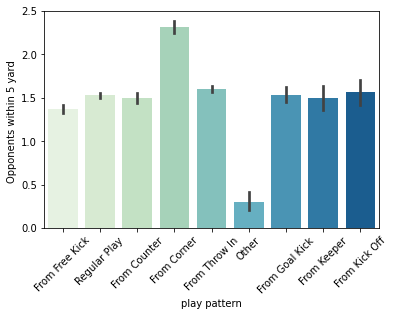

In [40]:
sns.barplot(y='Number of opponents in 5 yards',x='play pattern',data=train,palette='GnBu')
plt.xticks(rotation=45)
plt.ylabel('Opponents within 5 yard ')

Text(0, 0.5, 'Players between goal')

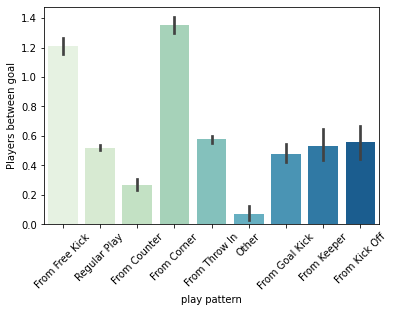

In [41]:
sns.barplot(y='Players between goal',x='play pattern',data=train,palette='GnBu')
plt.xticks(rotation=45)
plt.ylabel('Players between goal')

As we can see that the number of players between the goal and the shot taker is the least when the play type is a counter attack.

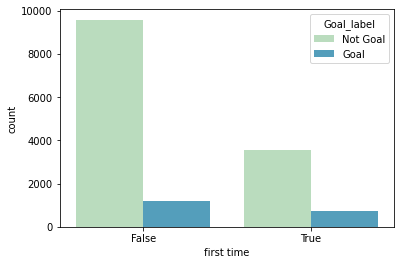

In [42]:
sns.countplot(x='first time',data=train,palette='GnBu', hue ='Goal_label')

It looks like shots taken first time result in goals on a higher rate. Let's analyze this further.

In [43]:
train.groupby('first time', as_index=False)['shot distance'].mean()

first time  shot distance
0       False      19.651858
1        True      16.764264

Text(0, 0.5, 'Distance')

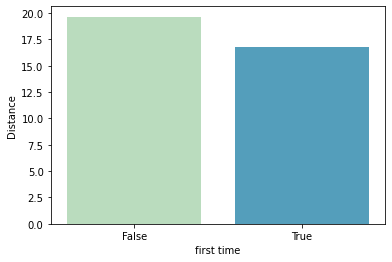

In [44]:
sns.barplot(y='shot distance',x='first time',data=train,palette='GnBu', ci=False)
plt.ylabel('Distance')

On an average, first time goals are shot from a distance of ~17 yards, while goals that are not scored are shot from ~20 yards.

Text(0, 0.5, 'Players between goal')

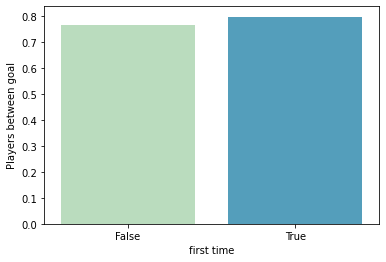

In [45]:
sns.barplot(y='Players between goal',x='first time',data=train,palette='GnBu', ci=False)
plt.ylabel('Players between goal')

Text(0, 0.5, 'Number of opponents in 5 yards')

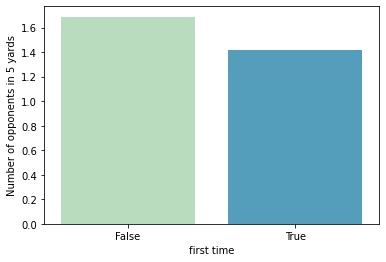

In [46]:
sns.barplot(y='Number of opponents in 5 yards',x='first time',data=train,palette='GnBu', ci=False)
plt.ylabel('Number of opponents in 5 yards')